# THIS NOTEBOOK IS DEDICATED TO THE ANALYSIS OF 

# *rev*


In [1]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
import types
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from pylab import *
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA

ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
root='/data'
%run UtilityTools.ipynb
%run Animal_Tags.ipynb
%run Lesion_Size.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
os.chdir(CWD)

# logging.getLogger().setLevel(logging.WARNING)
param={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }
Y1,Y2=(0,90)
BadLateRats=('Rat223','Rat231')
print('Done')

Done


In [122]:
def plot_event_1on1(root, SessionDict, TaskParamToPlot,
                    ax=None, preSlice=slice(-5,None), postSlice=slice(0,5)):
    
    Plot = True
    if ax is None:
        Plot=False
    
    
    Results,nSessionPre,nSessionPost=event_statistic2(root,
                                                     SessionDict,
                                                     parameter=param,
                                                     redo=False,
                                                     TaskParamToPlot=[TaskParamToPlot])

    data=np.array(list(Results[TaskParamToPlot].values()))
    slicedPreData  = np.ones((data.shape))*np.nan
    slicedPostData = np.ones((data.shape))*np.nan
    
    for row,Dnan in enumerate(data):
        Dpre= Dnan[:nSessionPre][~ np.isnan(Dnan[:nSessionPre])]
        Dpost=Dnan[nSessionPre:][~ np.isnan(Dnan[nSessionPre:])]
        preData =Dpre[preSlice]
        postData=Dpost[postSlice]

        slicedPreData[row,:len(preData)]=preData
        slicedPostData[row,:len(postData)]=postData
    
    y0=np.nanmean(slicedPreData,axis=1)
    y1=np.nanmean(slicedPostData,axis=1)
    
    y=np.array([y0,y1]).T
    
    if Plot:
        #plotting the errorbar
        props={'color':'k','linewidth':1}
        ax.boxplot(x=y,whis=[5,95],
                      positions=[-.5,.5], widths=.3,
                      showcaps=False, showfliers=False,
                      medianprops=props, boxprops=props, whiskerprops=props,
                      zorder=2)

        #plotting single animals
        for before,after in y:
            ax.plot([-.5,.5],[before,after],lw=.5,alpha=1,zorder=1)
        
    return y, slicedPreData, slicedPostData

## final speed

In [138]:
def reverse_trd_last_speed(data,win=.4,onlyGood=False):
    data.position_correction()
    detect_trial_end(data)
    
    cs=data.cameraSamplingRate
    trdSpeed=stats.mode(data.treadmillSpeed)[0]
    posArray=get_positions_array_end_StereotypedTrials(data,onlyGood=onlyGood)
    finalSpd=[]
    for pos in posArray:
        if len(pos) < int(win*cs):
            continue
        
        if pos[0] < 50:
            continue

        lastPos=pos[-int(win*cs):]
        dis=np.amax(lastPos) - np.amin(lastPos)
        spd=dis/win
        spd-=trdSpeed

        finalSpd.append(spd)
    finalSpd=np.array(finalSpd)
    
    finalSpd=finalSpd if len(finalSpd)>30 else np.array([np.nan])
    
    return np.nanmean(finalSpd)

In [2]:
profile1={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['6','8','10'],
         'Speed':['6','8'],
         'Tag':['Reverse','Reverse-AfterBreak']
         }
profile2={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['6','8','10'],
         'Speed':['6','8'],
         'Tag':['Reverse-Late_DLS',]
         }

Profiles=(profile1,profile2)
TaskParamToPlot='reverse_trd_last_speed'
preSlice=slice(-5,None)
postSlice=slice(0,1)

badAnimalList=[]
_,SessionDict=event_detect(root, Profiles[0], Profiles[1],badAnimals=badAnimalList)

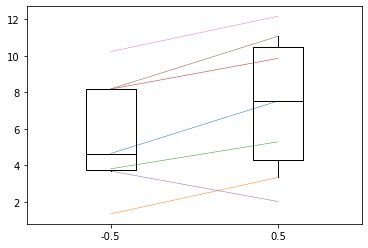

In [140]:
F=plt.figure(1)
ax=F.add_subplot(111)

y, nSessionPre, slicedPostData=plot_event_1on1(root,SessionDict, TaskParamToPlot=TaskParamToPlot,
                                               ax=ax, preSlice=preSlice, postSlice=postSlice);

In [141]:
for i,animal in enumerate(SessionDict.keys()):
    print(i, animal,y[i,0],y[i,1],y[i,1]-y[i,0] ,sep='\t')
#     if y[i,1] < 0.4:
#         print(i, animal, y[i,0],y[i,1], sep='\t')


0	Rat325	4.649118060710354	7.525534700388014	2.87641663967766
1	Rat337	1.345392693770338	3.3397973670900862	1.9944046733197482
2	Rat341	3.812443116518094	5.291222301691446	1.4787791851733525
3	Rat345	8.174704715256903	9.857933242541066	1.6832285272841627
4	Rat333	3.6892260915437993	2.024558460466854	-1.6646676310769455
5	Rat365	8.181300832920831	11.069461579520894	2.8881607466000627
6	Rat329	10.227702811048186	12.162056426692134	1.934353615643948


## InterTrial speed

In [146]:
class ReverseRunningSpeed:
    '''
    This class detects the running forward portion of the 
    trials and returns the forward speed
    
    '''
    def __init__(self,data,minXBack=60,minXFront=40):
        assert isinstance(data,Data), 'input data is not an instance of Data class'
        
        self.cs          =int(data.cameraSamplingRate)
        self.posDict     =data.position
        self.xBack       =minXBack
        self.xFront      =minXFront
        self.interTrialDuration=data.interTrialDuration
        self.forwardSpeed=None
    
    def compute(self):
        cs=self.cs
        forwardSpeed={}
        for trial,Pos in self.posDict.items():
            it=int(self.interTrialDuration[trial]*cs)-cs   #1s is not recorded
            pos= Pos[-it:]
            pos=90-pos

            back_P = (pos >self.xBack).astype(int)
            _backCross=back_P-np.concatenate((np.array([False]),back_P[:-1]))
            backCrosses=np.where(_backCross==-1)[0]
            if len(backCrosses)==0:
                continue
            else:
                backCross=backCrosses[0]

            front_P= (pos >self.xFront).astype(int)
            _frontCross=front_P-np.concatenate((np.array([False]),front_P[:-1]))
            frontCrosses=np.where(_frontCross==-1)[0]
            #detect first front cross after a back cross
            frontCross=frontCrosses[frontCrosses>backCross]
            if len(frontCross)==0:
                continue
            else:
                frontCross=frontCross[0]
                            
            
            forwardSpeed[trial]=(
                                 abs(
                                     (pos[backCross]-pos[frontCross])/(frontCross-backCross)
                                    )*self.cs
                                 )
        
        self.forwardSpeed=forwardSpeed

        return self.forwardSpeed

def _reverse_trd_IT_speed(data):
    a=ReverseRunningSpeed(data).compute()
    return np.mean(list(a.values()))

In [147]:
session='Rat345_2019_04_10_14_36'
data=Data(root,animal=session[:6],experiment=session,param=defaultParam,redoPreprocess=False,PrintWarning=True)

Preprocess behavior data loaded from /data/Rat345/Experiments/Rat345_2019_04_10_14_36/Analysis/preprocesseddata_binsize250ms_.p


In [148]:
a=_reverse_trd_IT_speed(data)
np.median(a)

69.97615561055497